In [ ]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installing dependencies
! pip install transformers datasets --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 29.7 MB/s eta 0:00:00


In [ ]:
# importing required libraries
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# reading the training dataset
train_df = pd.read_csv('/content/drive/MyDrive/SEM6/NLP/Project/data/clean_train.csv')
train_df.head()

,headline,label
0,CWG18 ಕುಸ್ತಿಯಲ್ಲಿ ಚಿನ್ನಗಳಿಸಿದ ರಾಹುಲ್ ಅವಾರೆ ಸುಶ...,1
1,ಏಷ್ಯಾ ಕಪ್ 2018 ಪಾಕ್ ವಿರುದ್ಧ ಘರ್ಜಿಸಲು ರೋಹಿತ್ ಸೈ...,1
2,ಸಮಂತಾ ವಿಷಯದಲ್ಲಿ ಯೂ ಟರ್ನ್ ಹೊಡೆದ ನಾಗ ಚೈತನ್ಯ,0
3,ಐಶ್ ಬೇಬಿ ಸೌಂದರ್ಯದ ಗುಟ್ಟು ರಟ್ಟು 40 ದಾಟಿದರೂ ಹಾಟ...,0
4,ಟೀಂ ಇಂಡಿಯಾ ಆಯ್ಕೆ ಸಮಿತಿ ಸದಸ್ಯರ ಸಂಭಾವನೆ ಎಷ್ಟು ಗೊ...,1


In [ ]:
# reading the testing dataset
test_df = pd.read_csv('/content/drive/MyDrive/SEM6/NLP/Project/data/clean_test.csv')
test_df.head()

,headline,label
0,ಬಜಾರ್ ಅಂಗಳದಲ್ಲಿ ಸಿಕ್ಕ ಧನ್ವೀರ್​,0
1,ಬಿಡುಗಡೆಯಾಯಿತು ಕಿಚ್ಚ ಸುದೀಪ್​ ಕಂಠದಾನ ಮಾಡಿರುವ ಸಿನ...,0
2,"ಸ್ಮಿತ್, ವಾರ್ನರ್​, ಬ್ಯಾಂಕ್ರಾಫ್ಟ್​ಗೆ ಶಿಕ್ಷೆ ಕಡಿತ...",1
3,ಬೆಂಗಳೂರು ಅಂತರ ರಾಷ್ಟ್ರೀಯ ಚಲನಚಿತ್ರೋತ್ಸವದಲ್ಲಿ ಏಷ್...,0
4,ಜಿಯೋ ಭರ್ಜರಿ ಗಿಫ್ಟ್​: ಇಂದಿನಿಂದಲೇ 5 ವರ್ಷಗಳ ಕಾಲ ಉ...,2


In [ ]:
# splitting the data into training and validation set
num_of_rows = int(len(train_df) * 0.8)
values = train_df.values
np.random.shuffle(values)
train_df = values[:num_of_rows] 
validation_df = values[num_of_rows:]
train_df = pd.DataFrame(train_df, columns = ['headline', 'label'])
validation_df = pd.DataFrame(validation_df, columns = ['headline', 'label'])
train_df.rename(columns = {'headline': 'text'}, inplace = True)
validation_df.rename(columns = {'headline': 'text'}, inplace = True)
test_df.rename(columns = {'headline': 'text'}, inplace = True)
print(train_df.shape, validation_df.shape, test_df.shape)

(3306, 2) (827, 2) (1293, 2)


In [ ]:
# loading dataset using Dataset Loader
train_df_hg = Dataset(pa.Table.from_pandas(train_df))
validation_df_hg = Dataset(pa.Table.from_pandas(validation_df))
test_df_hg = Dataset(pa.Table.from_pandas(test_df))

In [ ]:
# tokenizing datasets using Kannada BERT
checkpoint = 'l3cube-pune/kannada-bert'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'] ,truncation = True)

train_df_tokenised = train_df_hg.map(tokenize_function, batched = True)
validation_df_tokenised = validation_df_hg.map(tokenize_function, batched = True)
test_df_tokenised = test_df_hg.map(tokenize_function, batched = True)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'tf')

Map:   0%|          | 0/3306 [00:00<?, ? examples/s]

Map:   0%|          | 0/827 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
# converting datasets to tensorflow datasets
tf_train_dataset = train_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_validation_dataset = validation_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_test_dataset = test_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# loading the model for classification
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, from_pt = True, num_labels = 3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# defining hyper parameters
num_epcochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 0.0, decay_steps = num_train_steps)
opt = Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [ ]:
# compiling the model
model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [ ]:
# adding early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 5 )

In [ ]:
# training the model
history = model.fit(tf_train_dataset, callbacks = early_stopping_callback, validation_data = tf_validation_dataset, epochs = 100, verbose = 2, batch_size = 128)

Epoch 1/100
414/414 - 72s - loss: 0.4026 - accuracy: 0.9208 - val_loss: 0.1682 - val_accuracy: 0.9625 - 72s/epoch - 175ms/step
Epoch 2/100
414/414 - 52s - loss: 0.2237 - accuracy: 0.9247 - val_loss: 0.2154 - val_accuracy: 0.9504 - 52s/epoch - 125ms/step
Epoch 3/100
414/414 - 52s - loss: 0.0864 - accuracy: 0.9779 - val_loss: 0.1597 - val_accuracy: 0.9637 - 52s/epoch - 127ms/step
Epoch 4/100
414/414 - 51s - loss: 0.0500 - accuracy: 0.9867 - val_loss: 0.1311 - val_accuracy: 0.9710 - 51s/epoch - 123ms/step
Epoch 5/100
414/414 - 49s - loss: 0.0335 - accuracy: 0.9915 - val_loss: 0.1353 - val_accuracy: 0.9674 - 49s/epoch - 117ms/step
Epoch 6/100
414/414 - 49s - loss: 0.0260 - accuracy: 0.9924 - val_loss: 0.1631 - val_accuracy: 0.9649 - 49s/epoch - 118ms/step
Epoch 7/100
414/414 - 50s - loss: 0.0190 - accuracy: 0.9958 - val_loss: 0.1675 - val_accuracy: 0.9625 - 50s/epoch - 122ms/step
Epoch 8/100
414/414 - 51s - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.1645 - val_accuracy: 0.9637 - 51s/epo

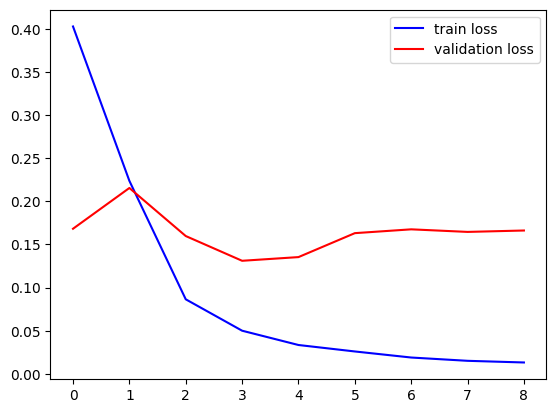

In [ ]:
# plotting the loss curve
plt.plot(history.history['loss'], c = 'b', label = 'train loss')
plt.plot(history.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

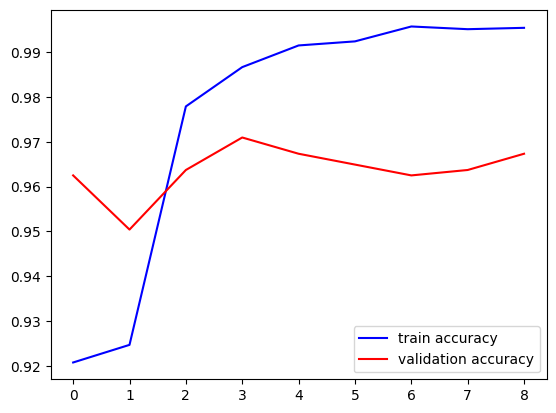

In [ ]:
# plotting the accuracy curve
plt.plot(history.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# using the trained model to predict the test labels
preds = model.predict(tf_test_dataset)['logits']
class_preds = np.argmax(preds, axis = 1)
print(preds.shape, class_preds.shape)

162/162 [==============================] - 11s 49ms/step
(1293, 3) (1293,)


In [ ]:
y_test = test_df.label.values
y_pred = class_preds

In [ ]:
# evaluating the predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.91%


In [ ]:
# printing the classification results
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       661
           1       0.97      0.96      0.96       470
           2       0.96      0.98      0.97       162

    accuracy                           0.97      1293
   macro avg       0.97      0.97      0.97      1293
weighted avg       0.97      0.97      0.97      1293



In [ ]:
# printing the confusion matrix for the classification
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[646  11   4]
 [ 19 449   2]
 [  2   2 158]]
